In [150]:
import rasterio
import netCDF4 as nc
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import glob

%matplotlib inline

In [151]:
class NCTOTIFF:
    def __init__(self,path,mode):
        self._filepath = path
        self._mode = mode
        self._raw = None
        self._data = None
        self._lat = None
        self._lon = None
        self._nx, self._ny = None, None
        self._step_lon, self._step_lat = None, None

    def read(self):
        self._raw = nc.Dataset(self._filepath)
        if '10m' == self._mode:
            self._lat = self._raw.variables['latitude'][:]
            self._lon = self._raw.variables['longitude'][:]
        elif 'chl' == self._mode:
            self._lat = self._raw.variables['lat'][:]
            self._lat = self._lat[::10,::10]
            self._lon = self._raw.variables['lon'][:]
            self._lon = self._lon[::10,::10]
            
        else:
            self._lat = self._raw.variables['lat'][:]
            self._lon = self._raw.variables['lon'][:]
        self._latmin = np.min(self._lat)
        self._lonmin = np.min(self._lon)
        self._latmax = np.max(self._lat)
        self._lonmax = np.max(self._lon)

        if self._mode == 'SST' or self._mode == 'SSS' :
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[0]
            self._lonstep = (self._lon[-1] - self._lon[0]) / self._nx
            self._latstep = (self._lat[-1] - self._lat[0]) / self._ny
        elif self._mode == 'SSC':
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[0]
            self._lonstep = (self._lon[-1] - self._lon[0]) / self._nx
            self._latstep = (self._lat[0] - self._lat[-1]) / self._ny
        elif self._mode == '10m':
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[1]
            self._lonstep = (self._lon[-1,0] - self._lon[0,0]) / self._nx
            self._latstep = ( self._lat[0,0] - self._lat[0,-1] ) / self._ny
            self._lon = self._lon.T
            self._lat = self._lat.T[::-1,:]
        else:
            self._nx, self._ny = self._lon.shape[1], self._lat.shape[0]
            self._lonstep = (np.max(self._lon) - np.min(self._lon)) / self._nx
            self._latstep = (np.max(self._lat) - np.min(self._lat)) / self._ny


        if self._mode == 'SST':
            interval = 'Daily' if 'Daily' in self._filepath else 'Hourly'
            self._data = self._raw.variables[f'{interval}_SST'][:]
        elif self._mode == 'SSS':
            self._data = self._raw.variables['DL_Interpolated_SSS'][:]
        elif self._mode == 'chl':
            self._data = self._raw.variables['merged_daily_Chl'][:]
            self._data = self._data[::10,::10]
            chl_nx, chl_ny = self._lon.shape[0], self._lat.shape[0]
            lon_grid = np.linspace(self._lonmin,self._lonmax,chl_nx)
            lat_grid = np.linspace(self._latmin,self._latmax,chl_ny)
            lon_grid, lat_grid = np.meshgrid(lon_grid,lat_grid)

            points = np.column_stack((self._lon.ravel(),self._lat.ravel()))
            values = self._data.ravel()

            self._data = griddata(points, values, (lon_grid, lat_grid), method='nearest')
            # self._data= self._data[::-1]
            self._lat = lat_grid
            self._lon = lon_grid

            
        elif self._mode == '10m':
            self._time = self._raw.variables['time'][:]
            self._time = [self.julian_to_date(t) for t in self._time]
            self._data = self._raw.variables['10m salinity'][:]
        else:
            self._time = self._raw.variables['time'][:]
            self._time = [self.julian_to_date(t) for t in self._time]
            self._U = self._raw.variables['us'][:]
            self._V = self._raw.variables['vs'][:]

    def julian_to_date(self,julian):
        date = datetime.fromordinal(int(julian)) + timedelta(days=julian%1) - timedelta(days = 366)
        return date.strftime("%Y%m%d")

    def save(self):
        savedir = '/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/LAST'

        filename = os.path.basename(self._filepath).replace('.nc','.tif')

        if not self._mode == '10m' and not self._mode == 'SSC':
            savepath = f'{savedir}/{self._mode}/{filename}'
            if not self._mode == 'chl':
                self._data.fill_value=-9999

                with rasterio.open(savepath, 'w', 
                            driver='GTiff', 
                            height=self._data.shape[0],
                            width=self._data.shape[1],
                            count=1, 
                            dtype=self._data.dtype,
                            crs='EPSG:4326', 
                            transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                            ) as dst:
                    dst.write(self._data, 1)
            else:
                with rasterio.open(savepath, 'w', 
                            driver='GTiff', 
                            height=self._data.shape[0],
                            width=self._data.shape[1],
                            count=1, 
                            dtype=self._data.dtype,
                            crs='EPSG:4326', 
                            transform=rasterio.transform.from_origin(self._lonmin,self._latmax,self._lonstep,self._latstep),
                            ) as dst:
                    dst.write(self._data, 1)

        
        elif self._mode == 'SSC':
            for i in range(len(self._time)):
                date = self._time[i]
                U = self._U[i,:,:]
                U = U[::-1,:]
                V = self._V[i,:,:]
                V = V[::-1,:]
                speed_data = np.sqrt(U**2+V**2)
                _data = (np.arctan2(V,-U)*(180/np.pi)+90)%360
                _data.fill_value=-9999
                savepath = f'{savedir}/{self._mode}/{date}_{filename}'
                with rasterio.open(savepath, 'w', 
                                driver='GTiff', 
                                height=_data.shape[0],
                                width=_data.shape[1],
                                count=2, 
                                dtype=_data.dtype,
                                crs='EPSG:4326', 
                                transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                                ) as dst:
                    dst.write(speed_data, 1)
                    dst.write(_data, 2)
        
            
        else:
            for i in range(len(self._time)):
                date = self._time[i]
                _data = self._data[i,:,:]
                if self._mode == '10m':
                    _data = _data.T
                    _data = _data[::-1,:]
                _data.fill_value=-9999

                savepath = f'{savedir}/{self._mode}/{date}_{filename}'


                with rasterio.open(savepath, 'w', 
                                driver='GTiff', 
                                height=_data.shape[0],
                                width=_data.shape[1],
                                count=1, 
                                dtype=_data.dtype,
                                crs='EPSG:4326', 
                                transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                                ) as dst:
                    dst.write(_data, 1)





In [152]:
mode = 'SSS'
fpath ='/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss'

In [153]:
filelist = glob.glob(f'{fpath}/*.nc')

In [154]:
for f in filelist:
    print(f)
    nctotiff = NCTOTIFF(f,mode)
    nctotiff.read()
    nctotiff.save()

/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200901_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200902_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200903_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200904_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200905_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200906_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200907_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200908_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200909_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200910_ML_Highresolution_SSS.nc
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/

## Data Read

In [156]:
TEST = NCTOTIFF('/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/sss/20200901_ML_Highresolution_SSS.nc','SSS')
TEST.read()

In [149]:
TEST._raw.variables

{'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
 unlimited dimensions: 
 current shape = (68,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float64 lon(lon)
 unlimited dimensions: 
 current shape = (64,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(t)
 unlimited dimensions: 
 current shape = (365,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'us': <class 'netCDF4._netCDF4.Variable'>
 float64 us(t, lat, lon)
 unlimited dimensions: 
 current shape = (365, 68, 64)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'vs': <class 'netCDF4._netCDF4.Variable'>
 float64 vs(t, lat, lon)
 unlimited dimensions: 
 current shape = (365, 68, 64)
 filling on, default _FillValue of 9.969209968386869e+36 used}

In [140]:
TEST._lon

array([[111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       ...,
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608]])

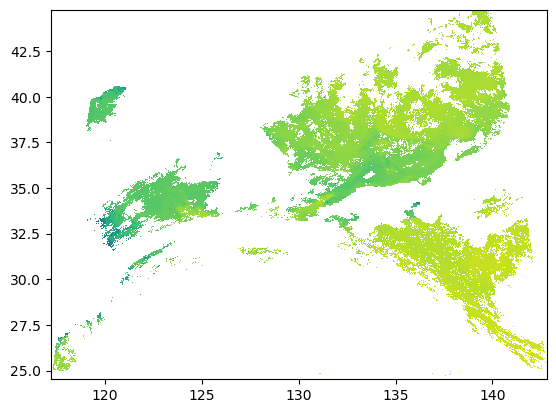

In [157]:
plt.pcolormesh(TEST._lon,TEST._lat,TEST._data)

In [52]:
TEST._lonmin, TEST._latmin, TEST._lonmax, TEST._latmax

(111.604034, 23.193302, 150.81699, 49.15555)

In [158]:
data = TEST._data
lon = TEST._lon
lat = TEST._lat

## 원본 데이터 DRAW

In [121]:
data.

(800, 800)

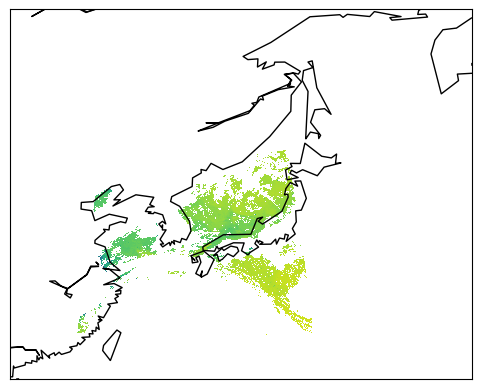

In [159]:
# 원본 데이터 draw
m = Basemap(projection='cyl',resolution='c', llcrnrlat=20, urcrnrlat=60, llcrnrlon=110, urcrnrlon=160)
m.drawcoastlines()
x,y = m(lon,lat)
m.pcolormesh(x,y,data,cmap='viridis')

## TEST1

### 직사각형의 배열 만든 후 매칭하기
- lon, lat 개수 지정
- linspace => 위경도 매칭
- searchsorted => 원본 데이터의 위경도 위치에 데이터 삽입

In [29]:
lon_num = int((TEST._lonmax-TEST._lonmin)/TEST._lonstep)

In [30]:
lat_num= -int((TEST._latmax-TEST._latmin)/TEST._latstep)

In [36]:
new_lon = np.linspace(TEST._lonmin,TEST._lonmax,lon_num)
new_lat = np.linspace(TEST._latmin,TEST._latmax,lat_num)
# new_lat = np.linspace(TEST._latmin,TEST._latmax,800)
new_lon_grid, new_lat_grid = np.meshgrid(new_lon,new_lat)

In [40]:
new_data_grid = np.full_like(new_lon_grid,fill_value=np.nan)

In [41]:
# TEST1
lon_indices = np.searchsorted(new_lon, TEST._lon)
lat_indices = np.searchsorted(new_lat, TEST._lat)

new_data_grid[lat_indices,lon_indices] = TEST._data

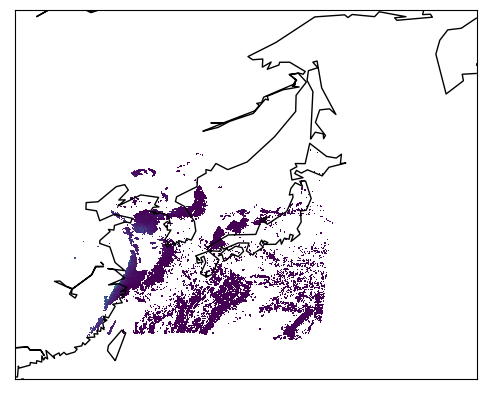

In [43]:
m = Basemap(projection='cyl',resolution='c', llcrnrlat=20, urcrnrlat=60, llcrnrlon=110, urcrnrlon=160)
m.drawcoastlines()
x,y = m(new_lon_grid,new_lat_grid[::-1])
m.pcolormesh(x,y,new_data_grid,cmap='viridis')

## TEST2

### Interpolation

In [53]:
from scipy.interpolate import RegularGridInterpolator

In [7]:
masked_vals = np.ma.masked_array(TEST._data)
masked_vals.mask = np.isnan(TEST._data)
# masked_vals = np.where(np.isnan(TEST._data), 0, TEST._data)
# masked_vals[masked_vals.mask == True] = 0

In [8]:
target_mask = np.where(masked_vals.mask == 0, 1, 0)

In [9]:
target_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
target_mask_ma = np.ma.masked_array(target_mask, mask=masked_vals.mask)

In [11]:
from scipy.interpolate import interp2d, griddata, LinearNDInterpolator, NearestNDInterpolator, RectBivariateSpline

In [12]:
def LinearND(lon1, lat1, data, lon2, lat2):

    if len(np.shape(lon1)) == 1 or len(np.shape(lat1)) == 1:
        lon1, lat1 = np.meshgrid(lon1, lat1)
    
    if len(np.shape(lon2)) == 1 or len(np.shape(lat2)) == 1:
        lon2, lat2 = np.meshgrid(lon2, lat2)

    data_mask = data.mask

    # print(lon1.shape, lat1.shape, data.shape, data_mask.shape)

    Ndinterp = LinearNDInterpolator((lon1[data_mask==0].ravel(), 
                                     lat1[data_mask==0].ravel()), 
                                     data[data_mask==0].ravel())

    filled_val = Ndinterp(lon2, lat2)

    return filled_val

In [13]:
def interp_Rect(lon1,lat1, data, lon2, lat2):
    # lon1, lat1 = 2d data grid
    # data = 2d data grid
    # lon2, lat2 = 2d data grid to be filled

    f = RectBivariateSpline(lon1,lat1,data)
    filled_val = f(lon2,lat2)
    return filled_val

In [14]:
def interp_griddata(lon1,lat1, data, lon2, lat2):
    # lon1, lat1 = 2d data grid
    # data = 2d data grid
    # lon2, lat2 = 2d data grid to be filled

    filled_val = griddata((lon1.ravel(), lat1.ravel()), data.ravel(), (lon2, lat2), method='linear')
    return filled_val

In [15]:
def interp_2d(lon1, lat1, data1, lon2, lat2):
    """
    This function interpolates 2d data with interp2d (linear interpolation)

      : input data1 has condition that data must fill all grid points
    ----www
    Input 
        - lon1  : 1d array (lon)      # source grid of interpolation area
        - lat1  : 1d array (lat)      # source grid of interpolation area
        - data1 : 2d array (lon, lat) # source grid of interpolation area
        
        - lon2  : 1d array (lon) # target grid of interpolation area
        - lat2  : 1d array (lat) # target grid of interpolation area
    Output
        - data2 : 2d array (lon, lat)
    """
    f = interp2d(lon1, lat1, data1, kind='linear')

    data2 = f(lon2, lat2)

    return data2

In [16]:
target_lon_1d = np.arange(TEST._lon[0].min(), TEST._lon[-1].max(), 0.05)
target_lat_1d = np.arange(TEST._lat[0].max(), TEST._lat[-1].min(), 0.05)

In [17]:
target_lon_2d, target_lat_2d = np.meshgrid(target_lon_1d, target_lat_1d)

In [20]:
source_lon_1d = TEST._lon[0][TEST._lon[0]<=target_lon_1d.max()]
source_lat_1d = TEST._lat[:,0][TEST._lat[:,0]>=target_lat_1d.min()]

In [53]:
target_lon_2d, target_lat_2d = np.meshgrid(target_lon_1d, target_lat_1d)

In [57]:
cvt_vals = LinearND(TEST._lon[::5,::5], TEST._lat[::5,::5], masked_vals[::5,::5], target_lon_2d, target_lat_2d)

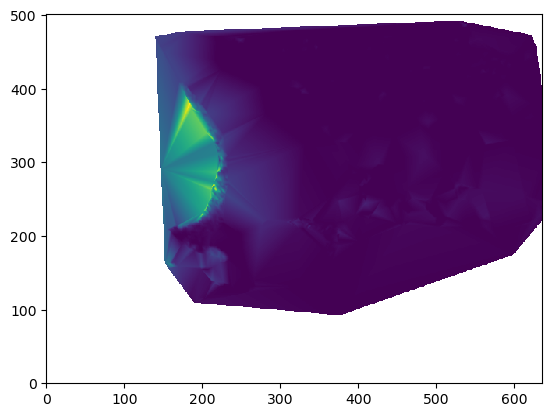

In [59]:
plt.pcolormesh(cvt_vals)